In [ ]:
# How many stacked exposures are required for a detection as a function of distance? 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


# Imports and setup

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import os
from astropy.io import fits
from astropy.table import Table, QTable
from astroduet.background import background_pixel_rate
from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence
from astroduet.image_utils import construct_image, estimate_background, find, ap_phot
from astroduet.diff_image import py_zogy, calculate_diff_image
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image

# Telescope parameters
duet = Telescope()
[bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi = True)
psf_fwhm_pix = duet.psf_fwhm / duet.pixel

# Simulation parameters
start_times = np.array([1800,3000,4200]) * u.s   # 30,50,70 minutes in seconds
distances = np.array([100,150,200,250,300]) * u.Mpc
frame = np.array([30,30])
exposure = 300 * u.s
psf_array = duet.psf_model(x_size=5,y_size=5).array

# 6 is oversampling used in construct_image() 
# - to-do: update sim_galaxy to accept r_eff in arcsec rather than pixels, so we can be agnostic about oversampling
oversample = 6
r_eff_init = 16.5/(duet.pixel.value/oversample) # Average r_eff for spiral galaxy at 100 Mpc, in pixels


# Suppress daophot warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

/Users/mheida/software/miniconda2/envs/duet/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [2]:
# Now that we have the files, loop through them, adding them until we reach a detection threshold of 5 sigma
debugdir = os.path.join(os.getcwd(), 'debug_imgs')

results = Table(names=('distance', 'pos', 'start_time', 'model', 'num_exp'), 
                dtype=('i2', 'i2', 'f2', 'S5', 'i2'))

# Loop through distances
distances = np.array([100,150,200,250,300]) * u.Mpc
err = False
for distance in distances:
    r_eff = r_eff_init * ((100*u.Mpc)**2 / distance**2) # r_eff for spiral galaxy at distance, in pixels
    r_eff = r_eff.value
    
    # Loop through three different source positions: r_eff*2, r_eff, r_eff/2, called 1, 2, 3
    for x_0, pos in zip([r_eff*2, r_eff, r_eff/2], [1,2,3]):            

        # Galaxy parameters
        gal_params = {'magnitude': 24, 'r_eff': r_eff, 'n': 1, 'theta': 0, 'ellip': 0.5, 'x_0': x_0, 'y_0': 0}
        
        # Generate combined reference image for this galaxy/source setup
        nexp = 5
        ref_image1 = construct_image(frame, exposure, duet=duet, band=duet.bandpass1,
                                     gal_type='custom', gal_params=gal_params, sky_rate=bgd_band1, n_exp=nexp)
        ref_image2 = construct_image(frame, exposure, duet=duet, band=duet.bandpass2,
                                     gal_type='custom', gal_params=gal_params, sky_rate=bgd_band2, n_exp=nexp)
        total_ref_rate = (ref_image1 + ref_image2) / (exposure * nexp)
        ref_bkg, ref_bkg_rms_median = estimate_background(total_ref_rate, method='1D', sigma=2)
        ref_bkgsub = total_ref_rate - ref_bkg
        
        # Loop through different start times
        for start_time in start_times:
            # Loop through different models
            for mod in ['shock','blukn']:
            
                # Grab the lightcurve files we need 
                name = '{}_{}Mpc_pos{}_{}s'.format(mod,np.int(distance.value),pos,np.int(start_time.value))
                table = Table.read(os.path.join(debugdir,name,name+'.hdf5'), path='default')
                
                # Loop through images, summing until we get a detection
                img_sum = np.zeros(frame) * u.ph / u.s
                for row in table:
                    # Add both bands and add them to total summed image
                    img_sum += (row['imgs_D1'] + row['imgs_D2']) * u.ph / u.s

                    # Convert to average rate
                    num_exp = row.index+1
                    img_rate = img_sum / (num_exp)

                    # Estimate background
                    img_bkg, img_bkg_rms_median = estimate_background(img_rate, method='1D', sigma=2)
                    img_bkgsub = img_rate - img_bkg

                    # Make difference image
                    diff_image = calculate_diff_image(img_rate, img_bkgsub, total_ref_rate, ref_bkgsub)

                    # Run find - do we detect an image to 5 sigma?
                    star_tbl, bkg_image, threshold = find(diff_image,psf_fwhm_pix.value,method='peaks', background='1D')
                    
                    if star_tbl[(star_tbl['x'] == (frame[0]//2)) & (star_tbl['y'] == (frame[1]//2))]: 
                        result, apertures, annulus_apertures = ap_phot(diff_image,star_tbl[(star_tbl['x'] == (frame[0]//2)) & (star_tbl['y'] == (frame[1]//2))],duet.read_noise,exposure)
            
                        # Sanity check, is this close to the rate that you put in:                        
                        found_rate = result['aperture_sum'].value
                        true_rate = duet.fluence_to_rate(row['fluence_D1']).value + \
                                    duet.fluence_to_rate(row['fluence_D2']).value
                        frac_diff = abs(found_rate - true_rate) / true_rate
                        if frac_diff > 0.8:
 #                           print(found_rate, true_rate, frac_diff)
                            print(mod, start_time.value, pos,distance,frac_diff, 'False Positive')
                        else:
                            # Source successfully found! End loop
                            results.add_row((distance, pos, start_time, mod, num_exp))
                            break
                    if num_exp > 15:
                        print(mod, start_time.value, pos,distance, 'Too many exposures')
                        results.add_row((distance, pos, start_time, mod, -1))
                        break

                    
#                 # Store the number of exposures that were required to detect the source in this setup


FileNotFoundError: [Errno 2] No such file or directory: '/Users/mheida/scripts/git/duet-astro/notebooks/debug_imgs/shock_100Mpc_pos1_1800s/shock_100Mpc_pos1_1800s.hdf5'

blukn 1 - 100 1
blukn 1 - 150 3
blukn 1 - 200 9
blukn 1 - 250 14
blukn 1 - 300 14
blukn 1 -- 100 1
blukn 1 -- 150 4
blukn 1 -- 200 4
blukn 1 -- 250 10
blukn 1 -- 300 16
blukn 1 : 100 1
blukn 1 : 150 2
blukn 1 : 200 2
blukn 1 : 250 3
blukn 1 : 300 -1
blukn 2 - 100 9
blukn 2 - 150 7
blukn 2 - 200 3
blukn 2 - 250 9
blukn 2 - 300 -1
blukn 2 -- 100 1
blukn 2 -- 150 2
blukn 2 -- 200 1
blukn 2 -- 250 13
blukn 2 -- 300 -1
blukn 2 : 100 2
blukn 2 : 150 2
blukn 2 : 200 4
blukn 2 : 250 5
blukn 2 : 300 15
blukn 3 - 100 3
blukn 3 - 150 3
blukn 3 - 200 14
blukn 3 - 250 -1
blukn 3 - 300 -1
blukn 3 -- 100 1
blukn 3 -- 150 10
blukn 3 -- 200 11
blukn 3 -- 250 -1
blukn 3 -- 300 -1
blukn 3 : 100 2
blukn 3 : 150 1
blukn 3 : 200 4
blukn 3 : 250 8
blukn 3 : 300 14


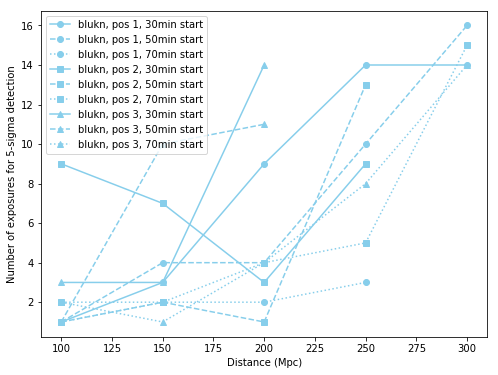

In [26]:
# Results plots - number of exposures vs distance for different models, start times, source positions
plt.figure(figsize=(8, 6))

# Loop through three different source positions
for mod, col in zip(['shock','blukn'],['coral','skyblue']):
    if mod is 'shock':
        continue
    # Loop through different models
    for pos,m in zip([1,2,3],['o','s','^']):

        # Loop through different start times
        for start_time, ls in zip(start_times,['-','--',':']):


            mask = (results['pos'] == pos) & \
                   (results['start_time'] == np.int(start_time.value)) & \
                   (results['model'] == mod)
            
            dist = results[mask]['distance']
            num = results[mask]['num_exp']
            
            for d, n in zip(dist, num):
                print(mod, pos,ls, d, n)

            mask = (results['pos'] == pos) & \
                (results['start_time'] == np.int(start_time.value)) & \
                (results['model'] == mod) & (results['num_exp'] > 0)

            dist = results[mask]['distance']
            num = results[mask]['num_exp']


            plt.plot(dist,num,marker=m,color=col,linestyle=ls,
                     label='{}, pos {}, {}min start'.format(mod,pos,np.int(start_time.to(u.min).value)))
plt.xlabel('Distance (Mpc)')
plt.ylabel('Number of exposures for 5-sigma detection')
plt.legend()

